In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_test = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/test.csv'

path_train = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/train.csv'

path_transactions = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/transactions.csv'

path_stores = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/stores.csv'

path_oil = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/oil.csv'

path_items = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/items.csv'

path_sample_submission = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/sample_submission.csv'

path_holidays_events = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/holidays_events.csv'



test = pd.read_csv(path_test)
transactions = pd.read_csv(path_transactions)
#train = pd.read_csv(path_train, nrows=2e6) #file is too large for colab RAM, therfore the nrows argument
stores = pd.read_csv(path_stores)
items = pd.read_csv(path_items)
oil = pd.read_csv(path_oil)
sample_submission = pd.read_csv(path_sample_submission)
holidays_events = pd.read_csv(path_holidays_events)

In [ ]:
# Select list of stores located in the 'Pichincha' region
store_ids = stores[stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv(path_train, chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-5-a4990095e953>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path_train, chunksize=chunk_size):


In [ ]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
#filtering for GROCERY I, CLEANING AND BEVERAGES
family_filter = ['GROCERY I', 'CLEANING', 'BEVERAGES']

items_filtered = items[items['family'].isin(family_filter)]

#create list of all item_nbr within those families
item_nbr_filter = list(items_filtered['item_nbr'].drop_duplicates())

In [ ]:
train_guayas = df_train[df_train['item_nbr'].isin(item_nbr_filter)]

**EDA**

In [ ]:
train_guayas.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN


In [ ]:
train_guayas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14745768 entries, 1 to 22941654
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 787.5+ MB


In [ ]:
#how many stores are there in Guayas
stores[stores['state'] == 'Guayas']['store_nbr'].nunique()

11

In [ ]:
#checking for missing values
train_guayas.isnull().any()

#filling nan values in onpromotion column with False
train_guayas['onpromotion'] = train_guayas['onpromotion'].fillna('False').astype('bool')

<ipython-input-14-d3d2840f9cd0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_guayas['onpromotion'] = train_guayas['onpromotion'].fillna('False').astype('bool')


In [ ]:
#finding out if there is missing steps in the time series
train_guayas['date'] = pd.to_datetime(train_guayas['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

#getting the range
date_min = df_train['date'].min()
date_max = df_train['date'].max()

#creating the range as df
full_date_range = pd.DataFrame({'date': pd.date_range(date_min, date_max)})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = train_guayas[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(train_guayas, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)



<ipython-input-17-6290cf840cb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_guayas['date'] = pd.to_datetime(train_guayas['date'])


In [ ]:
#checking for negative sales
negative_sales = df_filled[df_filled['unit_sales'] < 0]

#replacing negative unit sales with 0
df_filled['unit_sales'] = df_filled['unit_sales'].apply(lambda x: max(x, 0))

In [ ]:
#creating a pure timeseries of total unit sales per day
sales_by_date = df_filled.groupby('date')['unit_sales'].sum()

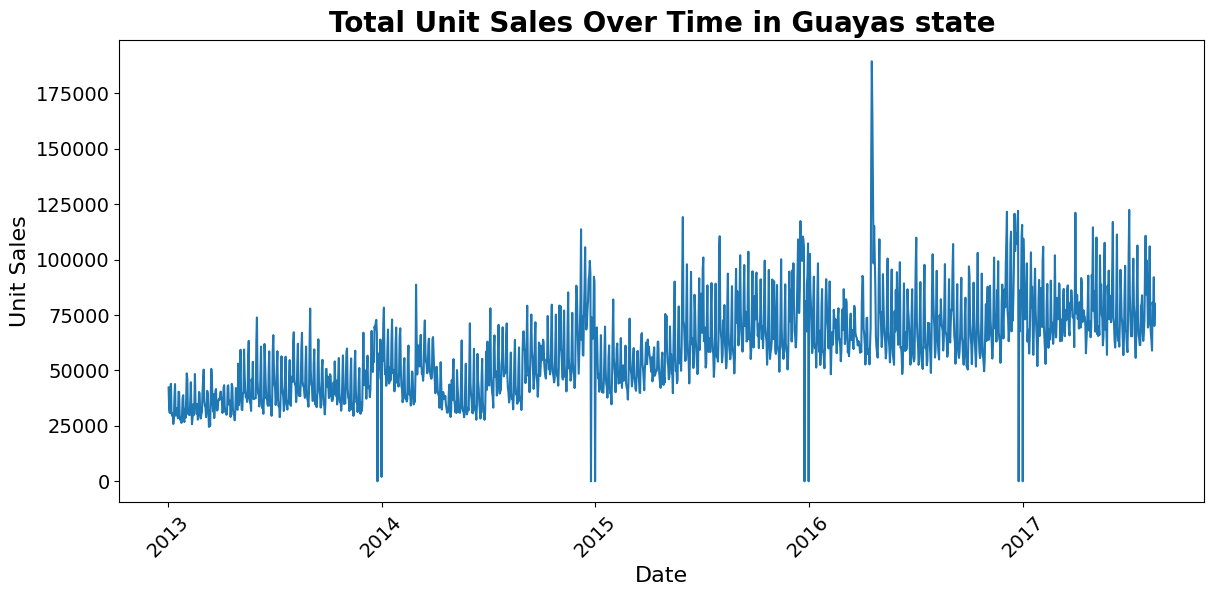

In [ ]:
#viizzzzz
plt.figure(figsize=(14,6))
plt.plot(sales_by_date)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
#creating additional features
df_filled['year'] = df_filled['date'].dt.year
df_filled['month'] = df_filled['date'].dt.month
df_filled['day'] = df_filled['date'].dt.day
df_filled['day_of_week'] = df_filled['date'].dt.dayofweek

In [ ]:
path_train_prepared = '/content/drive/My Drive/Data Analytics/retail_kaggle_data/train_prepared.csv'

df_filled.to_csv(path_train_prepared, index=False)